#1. Project Overview & Business Context

# System Activity & Visit Log Analysis

## Business Context
Organizations rely on system activity logs to understand user behavior,
monitor system usage, and ensure reliable reporting.

Raw log data is often unstructured and may contain missing records,
duplicates, or abnormal patterns that can impact reporting accuracy.

This project demonstrates an end-to-end data analysis workflow using
public web server access logs, focusing on data cleaning, activity analysis,
and anomaly detection to support reliable operational insights.

## Business Questions
1. What are the overall activity and visit patterns over time?
2. Are there periods with unusually high or low activity?
3. Which visitors generate the most traffic?
4. What anomalies should be monitored to ensure data reliability?

#2. Import Libraries & Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip access.log.zip -d logs

Archive:  access.log.zip
  inflating: logs/access.log         


In [ ]:
log_file = "logs/access.log"

#3. Parse Raw Log File -> Structured Data

In [ ]:
import re

pattern = (
    r'(?P<host>\S+) \S+ \S+ '
    r'\[(?P<time>.*?)\] '
    r'"(?P<method>\S+) (?P<endpoint>\S+) \S+" '
    r'(?P<status>\d+) (?P<size>\S+)'
)

rows = []

with open(log_file, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        match = re.search(pattern, line)
        if match:
            rows.append(match.groupdict())

df = pd.DataFrame(rows)
df.head()

,host,time,method,endpoint,status,size
0,54.36.149.41,22/Jan/2019:03:56:14 +0330,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577
1,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,/image/60844/productModel/200x200,200,5667
2,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,/image/61474/productModel/200x200,200,5379
3,40.77.167.129,22/Jan/2019:03:56:17 +0330,GET,/image/14925/productModel/100x100,200,1696
4,91.99.72.15,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483


#4. Raw Data - Understanding Finding

## Raw Log Findings

- The dataset consists of raw web server access logs.
- Each row represents a single access request (visit or activity).
- Data is unstructured and requires parsing before analysis.
- Some records do not match the expected format and are excluded.


#5. Data Cleaning & Feature Engineering

In [ ]:
df["timestamp"] = pd.to_datetime(
    df["time"], format="%d/%b/%Y:%H:%M:%S %z", errors="coerce"
)

df = df.dropna(subset=["timestamp"])

df["status"] = df["status"].astype(int)
df["size"] = df["size"].replace("-", 0).astype(int)

df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour

df = df.drop_duplicates()

df.head()

,host,time,method,endpoint,status,size,timestamp,date,hour
0,54.36.149.41,22/Jan/2019:03:56:14 +0330,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,2019-01-22 03:56:14+03:30,2019-01-22,3
1,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,/image/60844/productModel/200x200,200,5667,2019-01-22 03:56:16+03:30,2019-01-22,3
2,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,/image/61474/productModel/200x200,200,5379,2019-01-22 03:56:16+03:30,2019-01-22,3
3,40.77.167.129,22/Jan/2019:03:56:17 +0330,GET,/image/14925/productModel/100x100,200,1696,2019-01-22 03:56:17+03:30,2019-01-22,3
4,91.99.72.15,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,2019-01-22 03:56:17+03:30,2019-01-22,3


#6. Data Quality & Preparation

## Data Quality Findings

- Invalid timestamps and malformed records were removed.
- Missing response sizes were handled explicitly.
- Duplicate requests were dropped to avoid overcounting.
- After preprocessing, the dataset is suitable for time-based
  activity and visit analysis.


#7. Overall Activity Volume (Daily Activity)

In [ ]:
daily_activity = (
    df.groupby("date")
      .size()
      .reset_index(name="request_count")
)

daily_activity.head()

,date,request_count
0,2019-01-22,2137966
1,2019-01-23,2300270
2,2019-01-24,1835116
3,2019-01-25,1818744
4,2019-01-26,2161612


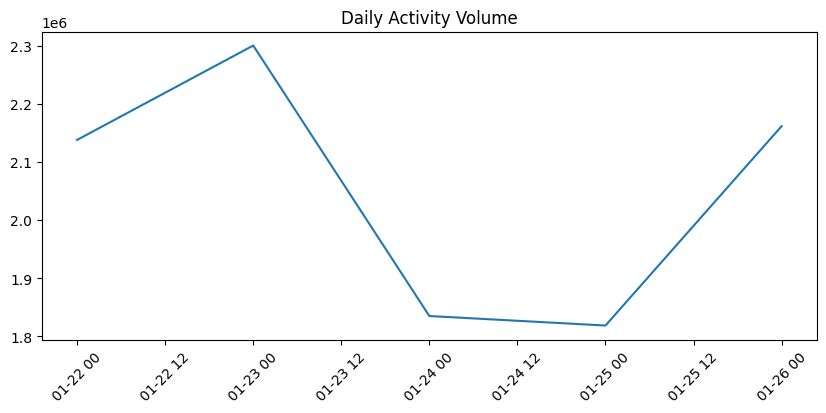

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(daily_activity["date"], daily_activity["request_count"])
plt.xticks(rotation=45)
plt.title("Daily Activity Volume")
plt.show()

#8. Activity Volume Analysis - Findings

## Daily Activity Findings

- Activity volume is not evenly distributed across time.
- Certain days show significantly higher request counts.
- Sudden drops may indicate missing logs or reduced system usage.


#9. Detect Low-Activity Days (Missing Log Indicator)

In [ ]:
threshold_low = daily_activity["request_count"].quantile(0.05)

low_activity_days = daily_activity[
    daily_activity["request_count"] < threshold_low
]

low_activity_days


,date,request_count
3,2019-01-25,1818744


#10. Missing Log Indicators - Finding

## Missing Activity Indicators

- Days with abnormally low request counts were identified.
- These periods may result from:
  - logging failures,
  - system downtime,
  - incomplete data ingestion.
- Such gaps can negatively affect reporting reliability.


#11. Visitor/Host Activity Analysis

In [ ]:
top_hosts = (
    df.groupby("host")
      .size()
      .reset_index(name="request_count")
      .sort_values(by="request_count", ascending=False)
)

top_hosts.head()

,host,request_count
205715,66.249.66.194,353406
205776,66.249.66.91,258523
11565,151.239.241.163,92082
205777,66.249.66.92,70501
250969,91.99.30.32,45725


#12. Visitor Behaviour - Findings

## Visitor Activity Findings

- A small number of hosts generate a disproportionate share of traffic.
- High-frequency activity may represent:
  - legitimate heavy users,
  - automated systems,
  - or abnormal usage patterns.
- This concentration should be monitored to understand its impact
  on system metrics.


#13. Hourly Activity Pattern

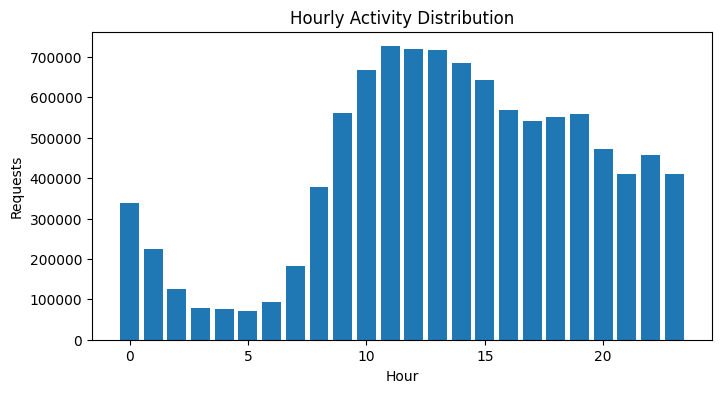

In [ ]:
hourly_activity = (
    df.groupby("hour")
      .size()
      .reset_index(name="request_count")
)

plt.figure(figsize=(8,4))
plt.bar(hourly_activity["hour"], hourly_activity["request_count"])
plt.title("Hourly Activity Distribution")
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.show()

#14. Temporal Pattern Analysis - Findings

## Hourly Pattern Findings

- Activity follows a clear hourly pattern.
- Peak traffic occurs during specific hours.
- Requests during off-hours may indicate automated
  processes or unexpected behavior.


#15. Final Insights & Business Recommendation

## Final Insights & Business Recommendations

System activity logs show uneven distribution across time and visitors,
with identifiable spikes, drops, and high-concentration usage patterns.

Periods of low activity may indicate missing logs or incomplete data
collection, reducing confidence in operational reporting.
A small group of visitors generates a large share of total requests,
making them important drivers of overall system activity metrics.

To support reliable analysis and reporting, organizations should implement
monitoring dashboards that track daily and hourly activity baselines,
highlight unusual spikes or drops, and flag abnormal visitor behavior.
Automated alerts for sudden activity changes and data completeness checks
should be integrated into regular operational workflows.

Institutionalizing log monitoring and data quality validation enables
more accurate reporting, faster issue detection, and better decision support.
